In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sc
import seaborn as sns

from statsmodels.distributions.empirical_distribution import ECDF

matplotlib.style.use('ggplot')

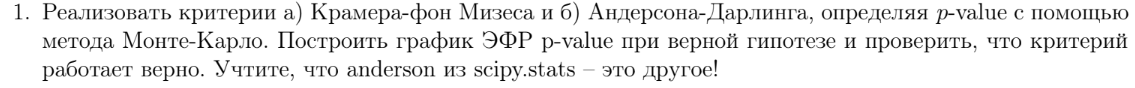

In [ ]:
#критерий принимает размер выборки и функцию распределения
def cramer_mises_uniform_value(sample, n):
    ans = 1/12/n
    sample = np.array(sample)
    sample = np.sort(sample)
    for i in range(1, n+1):
        ans += ((2*i - 1)/2/n - sc.stats.uniform.cdf(sample[i-1]))**2
    return ans

#сгенерируем таблицу приближенных квантиелей
f = open('quantiles/quantiles.txt', 'w')

table = []
for i in range(1000):
    sample = sc.stats.uniform.rvs(size=300)
    val = cramer_mises_uniform_value(sample, 300)
    table.append(val)
    
table = np.array(table)
table = np.sort(table)

for i in range(len(table)):
    print(table[i])
    f.write(str(table[i]) + ' ')
    
f.close()

In [3]:
#H0: N(0, 1)
def cramer_mises_normal(sample, n):
    ans = 1/12/n
    sample = np.array(sample)
    sample = np.sort(sample)
    for i in range(1, n+1):
        ans += ((2*i - 1)/2/n - sc.stats.norm.cdf(sample[i-1]))**2
    return ans

def get_quantile(a):
    f = open('quantiles/quantiles.txt', 'r')
    data = f.read()
    data = data.split(" ")
    return float(data[int(a * (len(data)-1))])

def counter(val):
    f = open('quantiles/quantiles.txt', 'r')
    data = f.read()
    data = data.split(" ")
    count = 0
    while float(data[count]) <= val:
        count += 1
        if count >= len(data)-1:
            break
    count /= len(data)
    return count

0.43222318614542415 0.4446080973280448 True


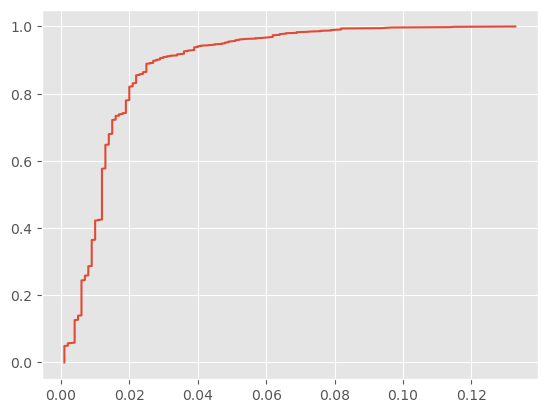

In [4]:
#Проверка гипотезы
n = 1000
a = 0.95
sample = sc.stats.laplace.rvs(size=n)
val = cramer_mises_normal(sample, n)
if val >= get_quantile(a):
    print(val, get_quantile(a), False)
else:
    print(val, get_quantile(a), True)
    
#График p-val
t = np.zeros(1000)
for i in range(1000):
    sample = sc.stats.laplace.rvs(size=n)
    t[i] = 1-counter(cramer_mises_normal(sample, n))

t = np.sort(t)
plt.plot(t, np.linspace(0, 1, 1000))

0.12374131748923256 0.4446080973280448 True


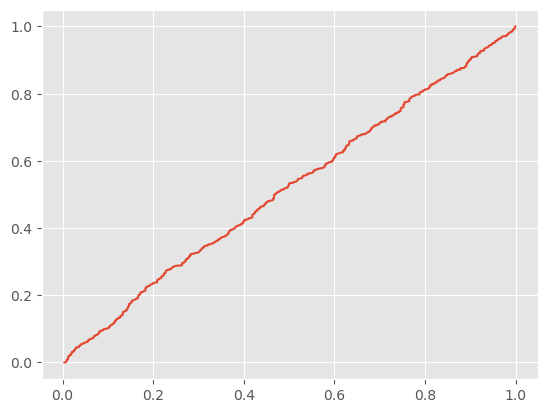

In [5]:
#Проверка гипотезы
n = 300
a = 0.95
sample = sc.stats.norm.rvs(size=n)
val = cramer_mises_normal(sample, n)
if val >= get_quantile(a):
    print(val, get_quantile(a), False)
else:
    print(val, get_quantile(a), True)
    
#График p-val
t = np.zeros(1000)
for i in range(1000):
    sample = sc.stats.norm.rvs(size=n)
    t[i] = 1-counter(cramer_mises_normal(sample, n))

t = np.sort(t)
plt.plot(t, np.linspace(0,1,1000))

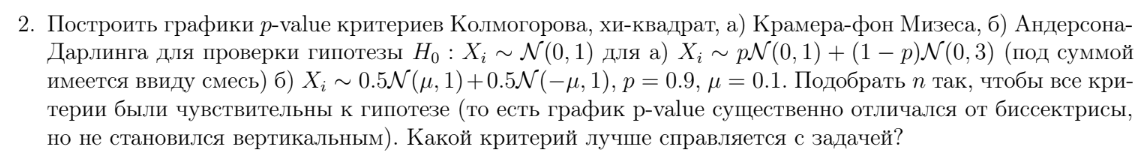

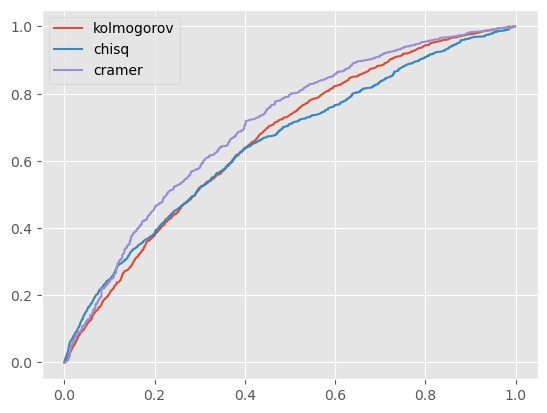

In [4]:
n = 1000
k = round(n**0.2)

kolmogi = []
chi = []
cramer = []

for i in range(n):
    p = sc.stats.bernoulli.rvs(0.9, size=n)
    X = sc.stats.norm.rvs(0, 1, size=n)
    Y = sc.stats.norm.rvs(0, 3**0.5, size=n)
    sample = p*X + (1-p)*Y
    
    #критерий Колмогорова
    kolmogi.append(sc.stats.kstest(sample, sc.stats.norm.cdf, alternative='two-sided').pvalue)
    
    #Хи-квадрат
    freq = np.zeros(k)
    quant = np.zeros(k+1)
    
    for j in range(k+1):
        quant[j] = sc.stats.norm.ppf(j/k)
        
    for j in range(n):
        for l in range(k):
            if quant[l] < sample[j] <= quant[l+1]:
                freq[l] += 1
                break
    chisqstat = 0
    for j in range(k):
        chisqstat += (freq[j] - n/k)**2/(n/k)
    chi.append(1 - sc.stats.chi2.cdf(chisqstat, df=k-1))
    
    #Крамер фон Мизес
    cramer.append(1 - counter(cramer_mises_normal(sample, n)))

t = np.linspace(0, 1, 1000)
plt.plot(np.sort(kolmogi), t, label='kolmogorov')
plt.plot(np.sort(chi), t, label='chisq')
plt.plot(np.sort(cramer), t, label='cramer')
plt.legend()

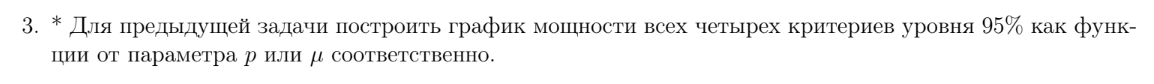

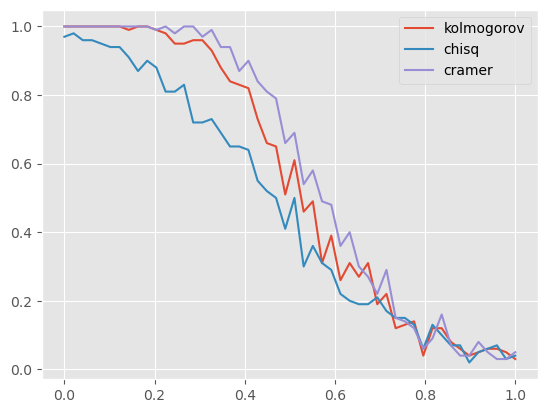

In [7]:
#Веро H1, но принимается H0
n = 200
k = round(n**0.2)

P = np.linspace(0, 1, 50)

kolmogi_val = []
chi_val = []
cramer_val = []

for p in P:
    kolmogi = 0
    chi = 0
    cramer = 0
    
    for i in range(100):
        bern = sc.stats.bernoulli.rvs(p, size=n)
        X = sc.stats.norm.rvs(0, 1, size=n)
        Y = sc.stats.norm.rvs(0, 3**0.5, size=n)
        sample = bern*X + (1-bern)*Y
        
         #критерий Колмогорова
        if (sc.stats.kstest(sample, sc.stats.norm.cdf, alternative='two-sided').pvalue < 0.05):
            kolmogi += 1
    
        #Хи-квадрат
        freq = np.zeros(k)
        quant = np.zeros(k+1)

        for j in range(k+1):
            quant[j] = sc.stats.norm.ppf(j/k)

        for j in range(n):
            for l in range(k):
                if quant[l] < sample[j] <= quant[l+1]:
                    freq[l] += 1
                    break
                    
        chisqstat = 0
        for j in range(k):
            chisqstat += (freq[j] - n/k)**2/(n/k)
        if 1 - sc.stats.chi2.cdf(chisqstat, df=k-1) < 0.05:
            chi += 1

        #Крамер фон Мизес
        if 1 - counter(cramer_mises_normal(sample, n)) < 0.05:
            cramer += 1
    
    kolmogi_val.append(kolmogi/100)
    chi_val.append(chi/100)
    cramer_val.append(cramer/100)
    
plt.plot(P, kolmogi_val, label='kolmogorov')
plt.plot(P, chi_val, label='chisq')
plt.plot(P, cramer_val, label='cramer')
plt.legend()